# CIFAR-10 Image Classification - Training your own Convolutional Neural Network #
## EECS 16ML, Fall 2021 ##

Written by Richard Shuai, Dohyun Cheon, Larry Yan, Tony Shara, Adi Ganapathi, 

richardshuai@berkeley.edu, dohyuncheon@berkeley.edu, yanlarry@berkeley.edu, anthony.shara@berkeley.edu, avganapathi@berkeley.edu, 

### Table of contents ###
* [Introduction](#introduction)  
* [Part 1: CIFAR-10 Image Classification](#part1)  
◦ Dataset Preprocessing  
◦ Visualizing a basic CNN  
◦ Train your own model  
* [Part 2: Tricking a CNN Classifier with Adversarial Examples](#part2)  
◦ Dataset Preprocessing  
* [Part 3: Implementing a Paper: ResNet](#part3)

<a id="introduction"></a>
# Introduction

In this notebook, you will gain more familiarity with intuition about convolutional neural network. You are also going to learn to classify images from the CIFAR-10 dataset with a simple convolutional neural network.
* First, we will visualize the filters and activations in the network in order to gain an intuition about what the convolutional neural network is actually learning.
* You will then implement your own convolutional neural network for image classification.
* With this model, you will learn to generate adversarial examples to feed into your newly trained model.
* Finally, you will be required to read the ResNet paper and implement a residual block layer.

Note that training the models in this notebook may take awhile, so make sure to start early.

<a id="part1"></a>

# Part 1: CIFAR-10 Image Classification

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model

from common_utils import *
import matplotlib.pyplot as plt

## Dataset Preprocessing

### Load in the CIFAR-10 Dataset

In [2]:
(X, Y), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

### Visualize a few images from the dataset

First, we'll plot some of the images to understand what we're actually classifying. The possible classes are given in the label_names array. Feel free to change num_visualize to see more images.

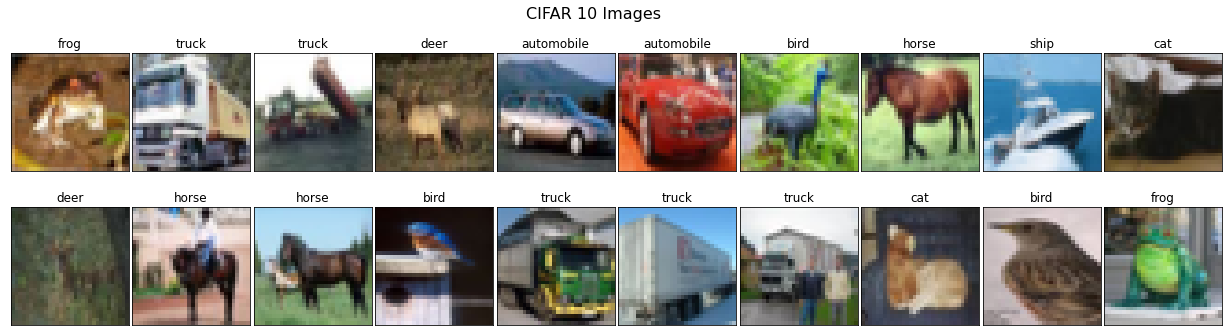

In [3]:
label_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Input the number of images to visualize
num_visualize = 20

# Construct a grid to plot images
labels = label_names[Y[:num_visualize].squeeze()] # Get label names in English from their 0-9 encodings
plot_labeled_image_grid(X[:num_visualize], labels, title='CIFAR 10 Images')

Note that the images from the CIFAR-10 dataset are unfortunately low resolution because each image is only 32x32 pixels. These images are small to help us focus on the classification task without worrying too much about computing power. 

## Create Train, Validation, and Test Datasets

Fill in the code to split the dataset into train and validation sets. Here, we will use a 90:10 split to create our train and validation datasets.

In [4]:
TRAIN_SPLIT = 0.9
NUM_TRAIN_SAMPLES = int(TRAIN_SPLIT * X.shape[0])

In [5]:
def train_val_split(X, Y, num_train_samples):
    N = X.shape[0]

    ### BEGIN CODE ###
    mask = np.zeros(N, dtype=np.bool)
    val_indices = np.random.choice(N, num_train_samples, replace=False)
    mask[val_indices] = True

    X_train = X[mask]    
    X_val = X[~mask]
    
    Y_train = Y[mask]
    Y_val = Y[~mask]
    ### END CODE ###

    return X_train, Y_train, X_val, Y_val

In [6]:
# Split dataset with our function
X_train, Y_train, X_val, Y_val = train_val_split(X, Y, NUM_TRAIN_SAMPLES)

In [7]:
# Sanity check for shapes
assert(X_train.shape == (45000, 32, 32, 3))
assert(X_val.shape == (5000, 32, 32, 3))
assert(Y_train.shape == (45000, 1))
assert(Y_val.shape == (5000, 1))

### Image Preprocessing

Preprocess the images in our dataset. There are several ways you can do this:
* Normalize the data from 0 to 1. 
* Subtract the mean of the training data
* Z-score standardization
* Dividing by 255 (for images ranging from 0 to 255)

Remember to apply the same preprocessing to the test and validation datasets as you do the train datasets. (For example, if the mean is calculated across the training data, subtract that same value from the validation and test sets).

In [8]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

### BEGIN CODE ###
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0
### END CODE ###

## Visualizing a CNN

In this section, we define and train a basic CNN and visualize the learned filters from the first layer as well as layer activations when classifying images.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=9, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])

For this classification task, we use categorical cross entropy loss. In Keras, since our data is not one-hot encoded, we use sparse categorical cross entropy loss, but this is equivalent to categorical cross entropy loss for one-hot encoded labels. This loss for each sample is defined as: 
$$L(x) = \displaystyle\sum_{k=1}^C -y_{k} \cdot log(\sigma(s)_k)$$

* $y_k = 1$ if the sample belongs to class $k$ and $y_k = 0$ is it does not belong to class $k$.
* $s$ is the score obtained from the last layer of the network before the activation function.
* $\sigma$ is the softmax activation function:
$$\sigma(z)_k = \frac{e^{z_k}}{\sum_{j=1}^{C} e^{z_j}}$$  

The loss is therefore
$$Loss = \frac{1}{N} \displaystyle\sum_{i=1}^{N} \displaystyle\sum_{k=1}^C -y_{i, k} \cdot log(\sigma(s_i)_k) $$  

where we average over the batch with batch size $N$.
We recommend you take some time to understand this loss intuitively by thinking about the 2-class case, with $C=2$.

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [11]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

Epoch 1/10
1407/1407 [==============================] - 6s 5ms/step - loss: 2.2303 - accuracy: 0.2275 - val_loss: 2.2329 - val_accuracy: 0.2260
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 2.1367 - accuracy: 0.3206 - val_loss: 2.1342 - val_accuracy: 0.3238
Epoch 3/10
1407/1407 [==============================] - 6s 4ms/step - loss: 2.1031 - accuracy: 0.3541 - val_loss: 2.1007 - val_accuracy: 0.3572
Epoch 4/10
1407/1407 [==============================] - 6s 4ms/step - loss: 2.0504 - accuracy: 0.4070 - val_loss: 2.0578 - val_accuracy: 0.3986
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 2.0176 - accuracy: 0.4394 - val_loss: 2.0229 - val_accuracy: 0.4344
Epoch 6/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.9830 - accuracy: 0.4734 - val_loss: 2.0050 - val_accuracy: 0.4498
Epoch 7/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.9524 - accuracy: 0.5051 - val_loss: 1.9618 - val_accuracy:

### Visualize learned filters

With this model, we can visualize the filters from the first convolutional layer to see what features the filters are detecting. As you should see, some of these filters look like edge-detecting filters.   
Note that here, we only extract the filters from the first convolutional layer because it is generally more difficult to interpret the convolutional filters from deeper layers. This is because these deeper layers act on encoded representations of images.

In [ ]:
def normalize(x):
    a = np.min(x)
    b = np.max(x)
    return (x - a) / (b - a)

In [ ]:
# Get the layers of the model in a list
layers = model.layers

# Extract the filters from the first convolutional layer
layer_0 = layers[0]
filters, biases = layer_0.get_weights()
filters = normalize(filters)

plot_image_grid(filters.transpose(3, 0, 1, 2), title='Learned Convolutional Filters')

Do any of these filters appear meaningful or recognizable? You may have seen similar filters from lecture or the notes.

Answer: Some filters appear to be detecting edges or features, and the variety of filter colors demonstrate responses to different colors.

### Visualize activations for certain images

We can also visualize the activations from the network when it makes predictions on certain images. This helps us understand how each filter encodes the image and transforms it through successive convolutional layers. Here, we demonstrate a visualization for the first layer activations. Fill in the code to visualize activations from the second and third convolutional layers. 

Hint: Insepct model.layers in order to understand the outputs of the activation_model.

In [ ]:
k = 2 # Change k to visualize different images in the training dataset.

img = X_train[k]
label = label_names[Y_train[k].squeeze()]

fig = plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.title(label)
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(model.input, layer_outputs)
activations = activation_model(img[np.newaxis, ...])

first_conv_activations = activations[0]

plot_image_grid(tf.squeeze(tf.transpose(first_conv_activations, [3, 0, 1, 2])), title='First Convolutional Layer Activations')

In [ ]:
second_conv_activations = None
third_conv_activations = None
### BEGIN CODE ###
second_conv_activations = activations[4]
third_conv_activations = activations[8]
### END CODE ###

plot_image_grid(tf.squeeze(tf.transpose(second_conv_activations, [3, 0, 1, 2])), title='Second Convolutional Layer Activations')
plot_image_grid(tf.squeeze(tf.transpose(third_conv_activations, [3, 0, 1, 2])), title='Third Convolutional Layer Activations')

Describe what you notice about the activations. How is the image transformed over successive layers?

Answer: The activations from the first convolutional layer preserve a lot of the original image, and this layer seems to be extracting features from the image. As we look at the activations from deeper convolutional layers, we can still recognize some features, but the activations become less interpretable. Intuitively, this is because the filters start to encode and extract the necessary information it needs to make its classification.

## Train Your Own Model

Now that we've developed a better intuitive understanding of how convolutional neural networks learn, it's time for you to implement a better architecture that can achieve a higher validation loss. Train a model to achieve a validation loss of at least 70% on CIFAR-10. 

Some tricks that might be helpful:
* Common kernel sizes are 3x3 or 5x5. Remember that larger kernel sizes can require a much larger number of parameters.
* Batch normalization can vastly speed up training by rescaling the inputs to each layer. It can also be act to regularize your network. You can read more about it here: https://arxiv.org/abs/1502.03167
* Architectures commonly make use of a CONV -> BATCH_NORM -> ACTIVATION -> CONV -> BATCH_NORM -> ACTIVATION -> POOLING pattern.
* Other ideas to test out include changing hyperparameters such as stride, adding dropout layers, and different optimization algorithms (https://ruder.io/optimizing-gradient-descent/).

You are given a lot of freedom to write the code for your architecture. Feel free to change any starter code if you feel like it's necessary.

In [ ]:
model = None

### BEGIN CODE ###
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, kernel_size=3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
])
## END CODE ###

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10)

### Visualize the learning curves

Plot the train loss and validation loss as a function of the number of epochs trained.

Hint: the history returned from model.fit may be helpful here.

In [ ]:
### BEGIN CODE ###
plt.title('Training and validation curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])
plt.show()
### END CODE ###

### Report the final loss on our test set

We evaluate the model once on the test set to achieve the final test accuracy.

In [ ]:
preds = model.evaluate(X_test, Y_test)

<a id="part2"></a>

# Part 2: Tricking a CNN Classifier with Adversarial Examples

As we have seen, CNNs are capable of classifying images with high accuracy. However, it turns out that it is very easy to "trick" a trained CNN classifier with *adversarial examples*. By taking a correctly classified image and adding a small but directed perturbation to the image, we can force the CNN to misclassify the image with high confidence. In this section, we will briefly demonstrate how we can cause your newly trained model to misclassify images with methods based on this paper: https://arxiv.org/abs/1412.6572. 

The change that we will be making is as follows:
$$\vec{x}_{adversarial} = \vec{x} + \epsilon \cdot sign(\nabla_x J(\theta, \vec{x}, y))$$  
where $J(\theta, \vec{x}, y))$ is the loss resulting from evaluating the model on an input image $\vec{x}$ with model parameters $\theta$, and $\epsilon$ is a small constant. Notice that we are taking the gradient with respect to the input image $x$ this time. Intuitively, this means that we are changing the image by making a small step in the direction that maximizes the loss the most under a max-norm constraint.

Fill in the code below to implement this update.

## Generate an adversarial example

In [ ]:
def generate_adversarial_example(model, x, y_true, eps=0.01):
    if len(x.shape) == 3:
        x = x[np.newaxis, ...]

    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    grad_x = tape.gradient(loss, x)
    
    adversarial_example = None

    ### BEGIN CODE ###
    adversarial_example = x + eps*np.sign(grad_x)
    ### END CODE ### 
    
    return (grad_x, adversarial_example)

For the purpose of our example, we want to make sure we perturb an image that the model would ordinarily be able to correctly classify. Obtain the index of such a correctly classified image in X_train and set it to variable idx.

In [ ]:
idx = None

### BEGIN CODE ###
Y_preds = model.predict(X_train)
correct_indices = np.where(np.argmax(Y_preds, axis=1) == Y_train.squeeze())[0]
idx = np.random.choice(correct_indices)
### END CODE ###

In [ ]:
# Visualize the original image and your model's prediction
img = X_train[idx]
y_true = Y_train[idx].squeeze()

plt.title(label_names[y_true])
plt.imshow(img)
plt.show()

With this correctly classified image, fill in the code below to generate an adversarial example that your model is likely to misclassify.

In [ ]:
eps = 0.01

### BEGIN CODE ###
grad_x = None
adversarial_img = None

grad_x, adversarial_img = generate_adversarial_example(model, img, y_true, eps=eps)
### END CODE ###

## Classification of the adversarial example

Run the forward pass of the model to find the prediction it makes on the adversarial input and set the label to label_new. You may need to slightly tune $\epsilon$ from above or change the original image in order to misclassify the image.

In [ ]:
label_new = None

### BEGIN CODE ###
y_preds_adversarial = model(adversarial_img)
label_new = label_names[np.argmax(y_preds_adversarial)]
### END CODE ###

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.set_title('Original prediction: {}'.format(label_names[y_true]), fontsize=16)
ax1.imshow(img)

ax2.set_title(r'$\vec{\epsilon} \cdot sign(\nabla_x J(\theta, \vec{x}, y))$', fontsize=16)
ax2.imshow(normalize(tf.squeeze(grad_x)))

ax3.set_title('Adversarial prediction: {}'.format(label_new), fontsize=16)
ax3.imshow(normalize(tf.squeeze(adversarial_img)))

plt.show()


<a id="part3"></a>
# Part 3: Implementing a Paper: ResNet

In developing machine learning models, it is valuable practice to be able to read a paper, understand it conceptually, and then to actually implement its architecture. Here, we will implement a key component of the architecture from the ResNet paper: residual blocks. These residual blocks can improve model accuracy and speed up training especially in deeper neural networks. By including a shortcut connection, it becomes easier for the network to learn an optimal function starting with the identity than completely from scratch.   

Read through the ResNet paper and fill in the code to implement a residual block with two layers. 
We've included a diagram from the picture for what specifically you should implement: use convolutional layers for the weight layers, and if the dimensions of $\vec{x}$ and $\mathcal{F}$ do not match, use a 1x1 convolution as the linear projection to match the dimensions.  
The ResNet paper can be found here: https://arxiv.org/abs/1512.03385

<img src="visuals/resnet_building_block.png" alt="Drawing" style="width: 50em;"/>

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        ### BEGIN CODE ###
        self.conv1 = tf.keras.layers.Conv2D(out_channels, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(out_channels, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.ReLU()
        
        self.skip = None
        if in_channels != out_channels:
            self.skip = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(out_channels, kernel_size=1, padding='same'),
                tf.keras.layers.BatchNormalization()
            ])
        ### END CODE ###
        
    def call(self, x):
        ### BEGIN CODE ###
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip:
            x = self.skip(x)
        out = out + x
        out = self.act2(out)
        ### END CODE ###
        return out

In [ ]:
### Sanity checking for the shapes of your outputs ###
x = tf.random.uniform([1, 5, 5, 3])

residual_block_1 = ResidualBlock(in_channels=3, out_channels=3, kernel_size=3)
residual_block_2 = ResidualBlock(in_channels=3, out_channels=7, kernel_size=3)

assert tuple(tf.shape(residual_block_1(x))) == (1, 5, 5, 3)
assert tuple(tf.shape(residual_block_2(x))) == (1, 5, 5, 7)

# Conclusion
Great job! You've successfully built your own CNN to classify images, learning how you can visualize the filters and activations of a trained model along the way. You also saw a bit about how small but selective perturbations can cause your CNN to misclassify relatively easily. Finally, you were able to practice reading and implementing a machine learning research paper. 

# References
Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (Sergey Ioffe, Christian Szegedy)  
https://arxiv.org/abs/1502.03167

An overview of gradient descent optimization algorithms (Sebastian Ruder)  
https://ruder.io/optimizing-gradient-descent/


Explaining and Harnessing Adversarial Examples (Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy)  
https://arxiv.org/abs/1412.6572

Deep Residual Learning for Image Recognition (Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun)  
https://arxiv.org/abs/1512.03385